In [1]:
# Let's import the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql.functions import datediff, to_date, lit, to_timestamp, col
from pyspark.sql.types import DateType

In [2]:
# create the session
spark = SparkSession.builder.getOrCreate()

# create the context
sc = spark.sparkContext

In [3]:
userProfile = spark.read.csv("data/users/public_users.csv", header = True)
egoTimeline1 = spark.read.csv("public_users_timelines_1.csv", header = True)
egoTimeline2 = spark.read.csv("public_users_timelines_2.csv", header = True)
egoTimeline = egoTimeline1.union(egoTimeline2)

userProfile = userProfile.filter("followers_count >= 1" or "following_count >= 1")

temp = userProfile.withColumn("record_date",userProfile['created_at'].cast(DateType()))
userProfileWithTime = temp.withColumn("days", datediff(to_date(lit("2020-12-12")),'record_date'))

userProfileWithTime = userProfileWithTime.withColumn("dailyTweetsAverage",lit(userProfileWithTime.tweet_count/userProfileWithTime.days))

In [4]:
userProfileWithTimePandas = userProfileWithTime.toPandas()
userProfileWithTimePandas = userProfileWithTimePandas[userProfileWithTimePandas["followers_count"].str.isdigit() == True]
userProfileWithTimePandas["followers_count"] = userProfileWithTimePandas["followers_count"].astype(int)

userProfileWithTimePandas = userProfileWithTimePandas[userProfileWithTimePandas["following_count"].str.isdigit() == True]
userProfileWithTimePandas["following_count"] = userProfileWithTimePandas["following_count"].astype(int)

userProfileWithTimePandas = userProfileWithTimePandas[userProfileWithTimePandas["tweet_count"].str.isdigit() == True]

In [11]:
egoTimeline.groupby("user_id").count().orderBy("count", ascending = False).show()
#egoTimeline.filter(egoTimeline["Value"] != False)
#egoTimeline
#egoTimeline.groupby("user_id").count().show()
#egoFiltered = egoTimeline.filter(egoTimeline["user_id"]== userProfileWithTime["id"])

+----------+-----+
|   user_id|count|
+----------+-----+
|         .|13900|
|2396176568| 3800|
|1330759578| 3800|
|1212342841| 3800|
|  36097879| 3800|
| 136886942| 3799|
| 160475411| 3797|
|1879468412| 3789|
|   6715202| 3780|
|2730768019| 3760|
| 204040664| 3758|
|1240234080| 3747|
| 201404747| 3737|
| 252744530| 3733|
| 386771443| 3671|
| 189787944| 3648|
|1256677638| 3640|
| 256500614| 3627|
| 318721655| 3625|
|2601717884| 3622|
+----------+-----+
only showing top 20 rows



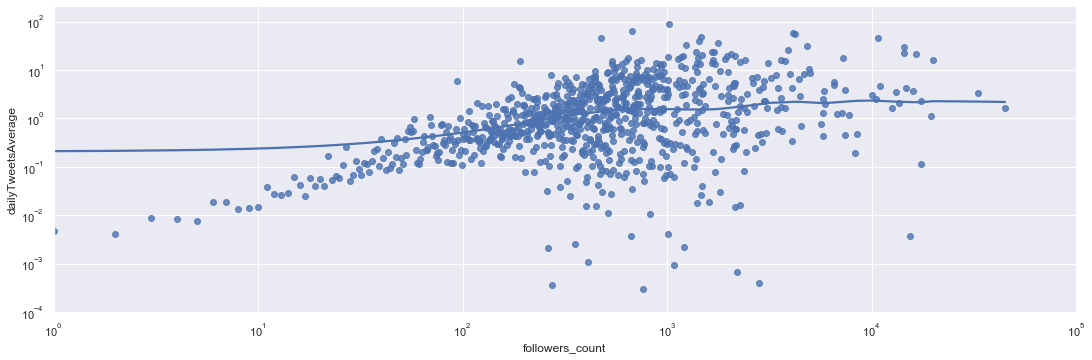

In [39]:
t = userProfileWithTimePandas.groupby("followers_count").mean().reset_index()
splot = sns.lmplot(x="followers_count", y="dailyTweetsAverage", data=t,
           lowess=True,
           aspect=3)

splot.set(xscale = "log")
splot.set(yscale = "log")
# control x and y limits
plt.ylim(0.0001, 200)
plt.xlim(1, 100000)

 
plt.show()


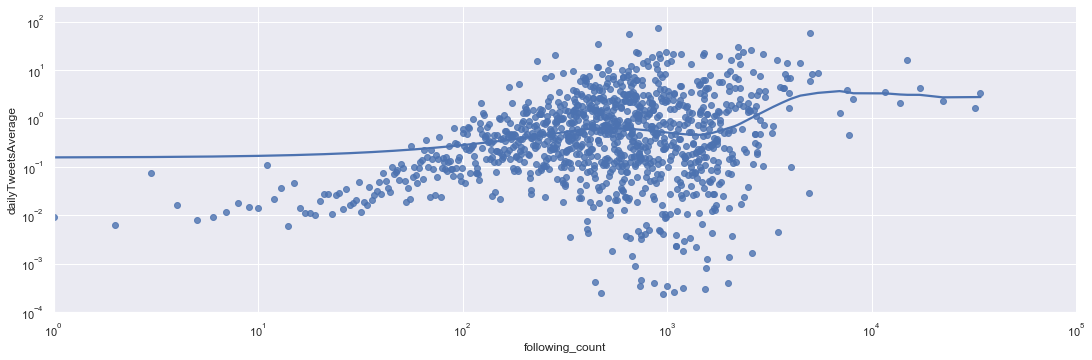

In [40]:
d = userProfileWithTimePandas.groupby("following_count").mean().reset_index()

splot = sns.lmplot(x="following_count", y="dailyTweetsAverage", data=d,
           lowess=True,
           aspect=3)

splot.set(xscale = "log")
splot.set(yscale = "log")
# control x and y limits
plt.ylim(0.0001, 200)
plt.xlim(1, 100000)

 
plt.show()


In [46]:
followingCor = np.log(userProfileWithTimePandas["following_count"])
followersCor = np.log(userProfileWithTimePandas["followers_count"])
dailyTweetCor= np.log(userProfileWithTimePandas["dailyTweetsAverage"])
tweetCountCor = np.log(userProfileWithTimePandas["tweet_count"].astype(int))


data = {'DailyTweetsAverage':dailyTweetCor , 'FollowersCount': followersCor, 'Following_count':followingCor }
cor1 = pd.DataFrame(data = data)
print(cor1.corr( method= 'pearson'))

data2 = {'TweetsCount':tweetCountCor , 'FollowersCount': followersCor, 'Following_count':followingCor }
cor2 = pd.DataFrame(data = data2)
print(cor2.corr( method= 'pearson'))

                    DailyTweetsAverage  FollowersCount  Following_count
DailyTweetsAverage            1.000000        0.744386         0.613695
FollowersCount                0.744386        1.000000         0.723578
Following_count               0.613695        0.723578         1.000000
                 TweetsCount  FollowersCount  Following_count
TweetsCount         1.000000        0.747128         0.610013
FollowersCount      0.747128        1.000000         0.723578
Following_count     0.610013        0.723578         1.000000
